In [1]:
!unzip mnist.zip # dataset -> https://www.kaggle.com/oddrationale/mnist-in-csv 

Archive:  mnist.zip
  inflating: mnist_test.csv          
  inflating: mnist_train.csv         


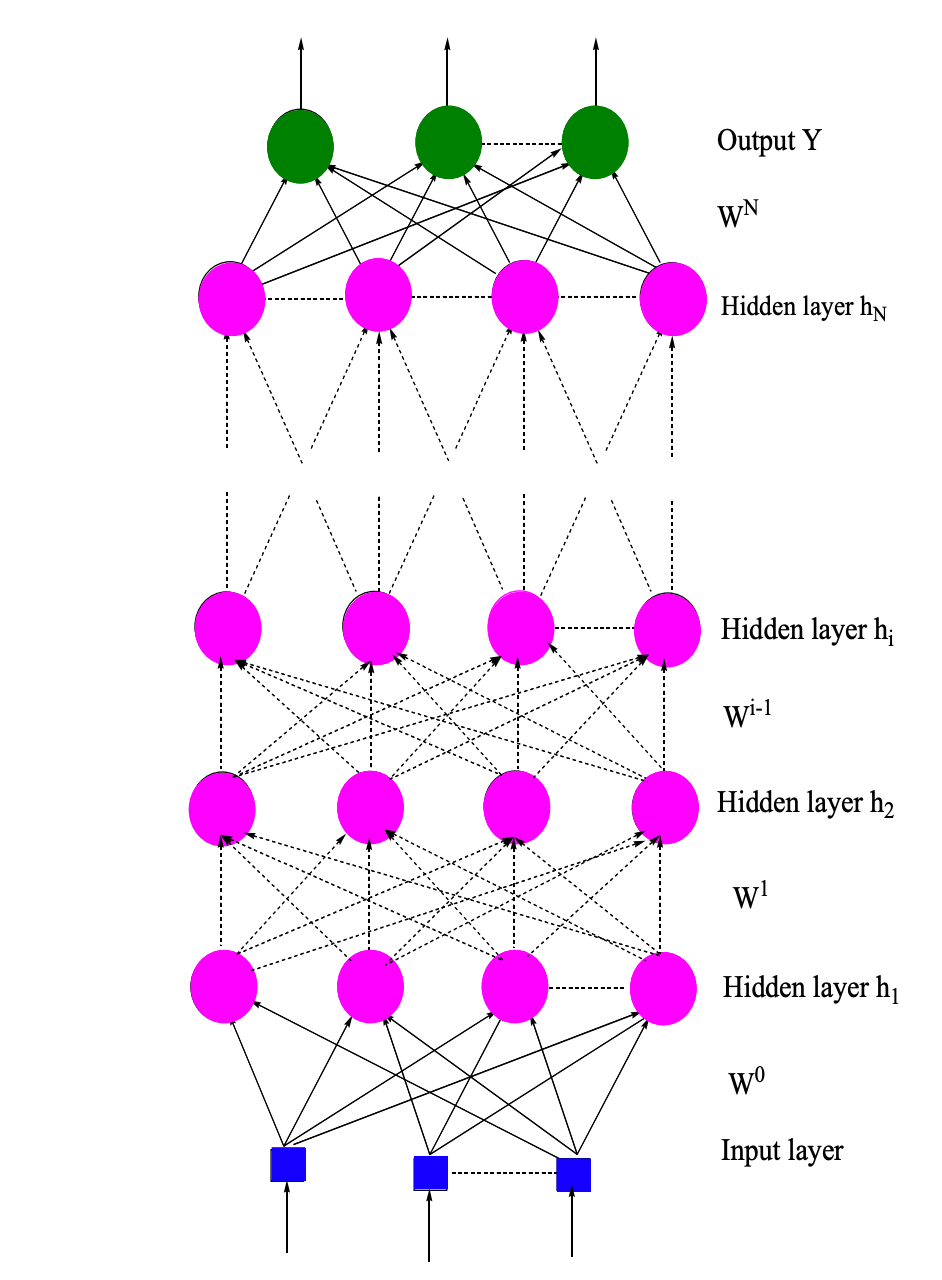 
<center> <i> Feed forward neural network architecture </i> </center>

In [2]:
import os
import numpy as np
from random import shuffle
import time
import pickle

CHECKPOINT = 'mlp_mnist.pkl'

# Activation function used here 
def ReLU(batch):
    '''
    Rectified Linear Unit : piecewise linear function that will output the input 
    directly if it is positive, otherwise, it will output zero.
    Read more at http://tiny.cc/relu-intro
    '''
    return batch.clip(min=0)

# Accuracy calculation
def Accuracy(labels, preds):
    '''
    Accuracy = Correct Predictions / Total Predictions
    Read more at http://tiny.cc/classification-accuracy
    '''
    return np.sum(labels == preds) / labels.shape[0]


class MLP(object):
    '''
    Multilayer Perceptron Class
    Read more at http://tiny.cc/mlp-intro
    '''

    # Defining Batch and Attribute dimensions
    BATCH_DIM, ATTR_DIM = 0, 1

    def __init__(self, layer_sizes, n_inputs, activation_fn, dropout=1.0):
        '''
        MLP Constructor 
        layer_sizes     : defines the layers of the perceptron
        n_inputs        : defines the input dimension
        activation_fn   : defines the activation function to be used at each layer
        dropout         : defines the % of layers for dropout (0.0 to 1.0). Default value is 1.0
        '''
       
        self.layer_sizes = layer_sizes
        self.input_dim = n_inputs
        self.layer_sizes.insert(0, self.input_dim)

        # Making an initial weight matrix according to the layer sizes
        self.weights = [np.zeros((layer_sizes[l-1], layer_sizes[l],), dtype=np.float32)
                        for l in range(1, len(layer_sizes))]
        print(self.n_layers)

        # Making the bias matrix 
        self.biases = [np.zeros((1, layer_sizes[l+1],), dtype=np.float32) for l in range(self.n_layers)]
        
        # Output dimension, number of classes for classification
        # 10 output classes; in this example
        self.out_dim = layer_sizes[-1]
        
        # Activation function to use
        self.activation_fn = activation_fn
        
        # No dropout for the output layer
        self.dropouts = [dropout for _ in range(self.n_layers-1)]
        print(self.dropouts)
        self.dropout_masks = []
        # Storing training loss and accuracies for plotting purposes
        self.train_losses = []          
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.best_loss = 1.0e+8

    @property
    def n_params(self):
        '''
        Function for the number of parameters
        '''
        n = 0
        for l in range(self.n_layers):
            n += (self.weights[l].shape[0] * self.weights[l].shape[1])
            n += (self.biases[l].shape[0] * self.biases[l].shape[1])
        return n
    
    def save_model_losses(self):
      pass
    def save_model(self, filename):
        '''
        Function to save the weights and biases in pickle file 
        '''
        with open(filename, 'wb') as f:
            weights = [w.tolist() for w in self.weights]
            biases = [b.tolist() for b in self.biases]
            pickle.dump((weights, biases, self.best_loss), f)

    def load_model(self, filename):
        '''
        Load the saved model
        '''
        with open(filename, 'rb') as f:
            weights, biases, self.best_loss = pickle.load(f)
            for l in range(self.n_layers):
                self.weights[l] = np.array(weights[l])
                self.biases[l] = np.array(biases[l])

    @property
    def n_layers(self):
        return len(self.weights)
    
    
    # Core of MLP classifier is forward and backpropagation
    # Forward propagation batch processing 
    def forward(self, batch, labels, in_train=True):
        x, z, self.dropout_masks = [batch], [], []
        raw_labels = np.argmax(labels, axis = 1)
        raw_labels = np.reshape(raw_labels, (-1, 1))
        # Steping layer by layer
        for l in range(self.n_layers):
            #        z = w*x + b
            # appending at last
            z.append(np.matmul(x[-1], self.weights[l]) + self.biases[l])
            
            # last value will hold the ouput of the present layer  
            layer_output = z[-1]
            if l < (self.n_layers - 1):
                # No Activation for final layer 
                layer_output = self.activation_fn(layer_output)
                if in_train:
                    # using the binomial distribution for the dropout probability
                    self.dropout_masks.append(np.random.binomial(1, self.dropouts[l], size=(1, z[-1].shape[1])) /
                                              self.dropouts[l])
                    layer_output *= self.dropout_masks[-1]
            x.append(layer_output)
            
        # Softmax
        # In the final layer, using Softmax to get final output layer
        row_max = np.max(x[-1], axis=self.ATTR_DIM, keepdims=True)

        modulo_row_max = x[-1] - row_max
        sexp = np.exp(modulo_row_max)
        exp_sum = np.sum(sexp, axis=self.ATTR_DIM, keepdims=True)
        s = sexp / exp_sum
        pred = np.argmax(s, axis = 1)

        accuracy = Accuracy(raw_labels, np.reshape(pred , (-1, 1)))

        # Computing the loss
        # Cross Entropy
        loss = np.mean(np.log(exp_sum) - np.sum((labels * modulo_row_max), axis=self.ATTR_DIM))
        return x, z, s, loss, accuracy

    def backprop(self, x, z, preds, y, lr):
        assert preds.shape == y.shape
        grads = []
        
        # Explicit differentiation of the cross entropy over soft-max
        gx = (preds - y)
        for l in range(self.n_layers-1, -1, -1):
            if l < (self.n_layers - 1):
                gz = np.copy(z[l])
                # For ReLU
                gz[gz < 0] = 0
                gz[gz > 0] = 1
                gz *= (gx * self.dropout_masks[l])
            else:
                gz = gx
            grad_w = np.mean(np.expand_dims(gz, axis=1) * np.expand_dims(x[l], axis=2), axis=0)
            grads.insert(0, (grad_w, np.mean(gz, axis=0, keepdims=True),))
            gx = np.matmul(gz, np.transpose(self.weights[l]))
            
        # Updating weights and biases 
        for l in range(self.n_layers):
            self.weights[l] -= lr * grads[l][0]
            self.biases[l] -= lr * grads[l][1]

    def random_init(self):
        for l in range(self.n_layers):
            self.weights[l] = np.random.randn(self.weights[l].shape[0], self.weights[l].shape[1])
            self.biases[l] = np.zeros((self.biases[l].shape[0], self.biases[l].shape[1]))

    def train(self, train_data, train_gt, val_data, val_gt, raw_val_labels, epochs, batch_size, lr, load_from=None):
        '''
        Function to train the model. 
        train_data    : Training data
        train_gt      : Target labels for train data
        val_data      : Validation data
        val_gt        : Target labels for validation data
        raw_val_labels: 
        epochs        : Number of epochs to be train
        batch_size    : Input batch size for each epoch
        lr            : Learning Rate
        load_from     : Path to previous weights and biases to be loaded to continue training
        '''
        # Loading if the model is already trained
        if load_from is not None and os.path.exists(load_from):
            self.load_model(load_from)
        
        input_dim, n_train_data = train_data.shape[self.ATTR_DIM], train_data.shape[self.BATCH_DIM]
        n_val_data = val_data.shape[self.BATCH_DIM]
        out_dim = train_gt.shape[self.ATTR_DIM]

        print(f'Training {self.n_params} Parameters')
        train_indices = [i for i in range(n_train_data)]
        n_train_batches = np.ceil(n_train_data / batch_size).astype(int)
        self.random_init()
        training_start = time.time()
        for epoch in range(epochs):
            l = 0
            a = 0
            shuffle(train_indices)
            for i in range(n_train_batches):
                # Training in batches
                batch_indices = train_indices[(i * batch_size):(i + 1) * batch_size]
                batch = np.take(train_data, batch_indices, axis=self.BATCH_DIM)
                batch_labels = np.take(train_gt, batch_indices, axis=self.BATCH_DIM)
                
                #Forward propagation
                x, z, s, batch_loss, batch_accuracy = self.forward(batch, batch_labels, in_train=True)
                l += batch_loss*batch_size
                a += batch_accuracy
                #backward propagation
                self.backprop(x, z, s, batch_labels, lr)
                if i % 10 == 0:
                    print(f'Epoch: {epoch+1}/{epochs}, Batch:{i}/{n_train_batches}: Loss - {batch_loss:.5f}: Accuracy - {batch_accuracy*100:.5f}%')
                if i > 0 and i % 100 == 0:
                    val_loss, val_accuracy = self.predict(val_data, val_gt, raw_val_labels,  batch_size)
                    print('-------------------------')
                    print(f'Current Validation Loss: {val_loss:.5f}, Accuracy: {val_accuracy*100:.3f}%')
                    print('-------------------------')

            val_loss, val_accuracy = self.predict(val_data, val_gt, raw_val_labels, batch_size)
            self.train_losses.append(l/n_train_data)
            self.train_accuracies.append(a/n_train_batches)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)
            print()
            print('-------------------------')
            print(f'After Epoch: {epoch + 1}/{epochs}, Validation Loss - {val_loss:.5f}, Validation Accuracy: {val_accuracy*100:.3f}%')
            time_elapsed = time.time() - training_start
            time_elapsed_min, time_elapsed_sec = int(time_elapsed) // 60, int(time_elapsed) % 60
            time_per_epoch = time_elapsed / (epoch + 1)
            time_per_epoch_min, time_per_epoch_sec = int(time_per_epoch) // 60, int(time_per_epoch) % 60
            print(f'Elapsed Time [{time_elapsed_min:>3}m {time_elapsed_sec:>2}s] @ '
                  f'[{time_per_epoch_min:>2}m {time_per_epoch_sec:>2}s] / Epoch')
            if val_loss < self.best_loss:
                self.save_model(CHECKPOINT)
                self.best_loss = val_loss
                print('Checkpoint Saved')
            print('-------------------------')
            print()

    def predict(self, dataset, labels, raw_labels, batch_size):
        input_dim, n_datapoints = dataset.shape[self.ATTR_DIM], dataset.shape[self.BATCH_DIM]
        # assert self.input_dim == input_dim
        # assert self.out_dim == labels.shape[self.ATTR_DIM] and n_datapoints == labels.shape[self.BATCH_DIM]
        indices = [i for i in range(n_datapoints)]
        n_batches = np.ceil(n_datapoints / batch_size).astype(int)
        predictions = np.zeros(n_datapoints, dtype=np.int)
        loss = 0.0
        for i in range(n_batches):
            
            # Running in batches
            batch_indices = indices[(i * batch_size):(i + 1) * batch_size]
            batch = np.take(dataset, batch_indices, axis=self.BATCH_DIM)
            batch_labels = np.take(labels, batch_indices, axis=self.BATCH_DIM)
            
            # For prediction just running the forward pass 
            x, z, s, batch_loss, accuracy = self.forward(batch, batch_labels, in_train=False)
            loss += (batch_loss * batch_size)
            batch_pred = np.argmax(s, axis=self.ATTR_DIM)
            predictions[batch_indices] = batch_pred
        accuracy = Accuracy(raw_labels, predictions)
        return (loss / n_datapoints), accuracy    

In [3]:
mnist_train_val = np.genfromtxt('mnist_train.csv', delimiter=',', skip_header=1)    #loading the data
    
# Removing garbage values
null_values = [list(mnist_train_val[:, 0].astype(int)).index(i) for i in mnist_train_val[:, 0].astype(int) if i < 0 or i > 10]    
mnist_train_val = np.delete(mnist_train_val, null_values, axis = 0)

# Dataset contains n flattened images of 28x28 with first columns as labels
n_data, n_cols = mnist_train_val.shape[0], (mnist_train_val.shape[1] - 1)    #n_cols = 784

# Shuffling and creating validation and test set of 20% and 80% split 
np.random.shuffle(mnist_train_val)
n_train = int(n_data * 0.8)
n_val = n_data - n_train
mnist_train, mnist_val = mnist_train_val[:n_train, :], mnist_train_val[n_train:, :]

del mnist_train_val

# Spliting the samples into train and val images
train_images, val_images = mnist_train[:, 1:] / 255.0, mnist_val[:, 1:] / 255.0
train_labels, val_labels = np.zeros((n_train, 10)), np.zeros((n_val, 10))

# Setting up the labels
train_labels[np.arange(n_train), mnist_train[:, 0].astype(int)] = 1
raw_val_labels = mnist_val[:, 0].astype(int)
val_labels[np.arange(n_val), mnist_val[:, 0].astype(int)] = 1

del mnist_val, mnist_train

# Class instantiation 
mlp = MLP([512, 256, 128, 10], n_cols, ReLU, dropout=0.75)

# Training the initialized model
mlp.train(train_images, train_labels, val_images, val_labels, raw_val_labels, 50, 512, 5.0e-5, load_from=CHECKPOINT)

4
[0.75, 0.75, 0.75]
Training 567434 Parameters
Epoch: 1/50, Batch:0/94: Loss - 26363.46393: Accuracy - 12.30469%
Epoch: 1/50, Batch:10/94: Loss - 18559.65491: Accuracy - 11.13281%
Epoch: 1/50, Batch:20/94: Loss - 14644.63253: Accuracy - 13.08594%
Epoch: 1/50, Batch:30/94: Loss - 13262.56348: Accuracy - 16.99219%
Epoch: 1/50, Batch:40/94: Loss - 14354.13640: Accuracy - 14.06250%
Epoch: 1/50, Batch:50/94: Loss - 14798.47349: Accuracy - 17.57812%
Epoch: 1/50, Batch:60/94: Loss - 11559.20185: Accuracy - 22.46094%
Epoch: 1/50, Batch:70/94: Loss - 11595.54025: Accuracy - 24.41406%
Epoch: 1/50, Batch:80/94: Loss - 8828.97398: Accuracy - 25.39062%
Epoch: 1/50, Batch:90/94: Loss - 7099.85105: Accuracy - 26.36719%

-------------------------
After Epoch: 1/50, Validation Loss - 2641.19733, Validation Accuracy: 46.742%
Elapsed Time [  1m 26s] @ [ 1m 26s] / Epoch
Checkpoint Saved
-------------------------

Epoch: 2/50, Batch:0/94: Loss - 11316.60092: Accuracy - 18.94531%
Epoch: 2/50, Batch:10/94: 

In [4]:
# Setting up the test set 
mnist_test = np.genfromtxt('mnist_test.csv', delimiter=',', skip_header=1)
n_test = mnist_test.shape[0]
print(f'Training: {n_train}, Validation: {n_val}, Test: {n_test}, Attributes: {n_cols}')
test_images, raw_test_labels = mnist_test[:, 1:] / 255.0, mnist_test[:, 0].astype(int)

del mnist_test 

test_labels = np.zeros((n_test, 10))
test_labels[np.arange(n_test), raw_test_labels] = 1
test_loss, test_accuracy = mlp.predict(test_images, test_labels, raw_test_labels, 32)
print(f'Final Test Loss: {test_loss:.5f}, Test Accuracy: {test_accuracy*100:.3f}%')

Training: 48000, Validation: 12000, Test: 10000, Attributes: 784
Final Test Loss: 12.17262, Test Accuracy: 37.670%


In [5]:
import matplotlib.pyplot as plt

In [6]:
a = mlp.train_accuracies
c = mlp.train_losses
b = mlp.val_accuracies
d = mlp.val_losses

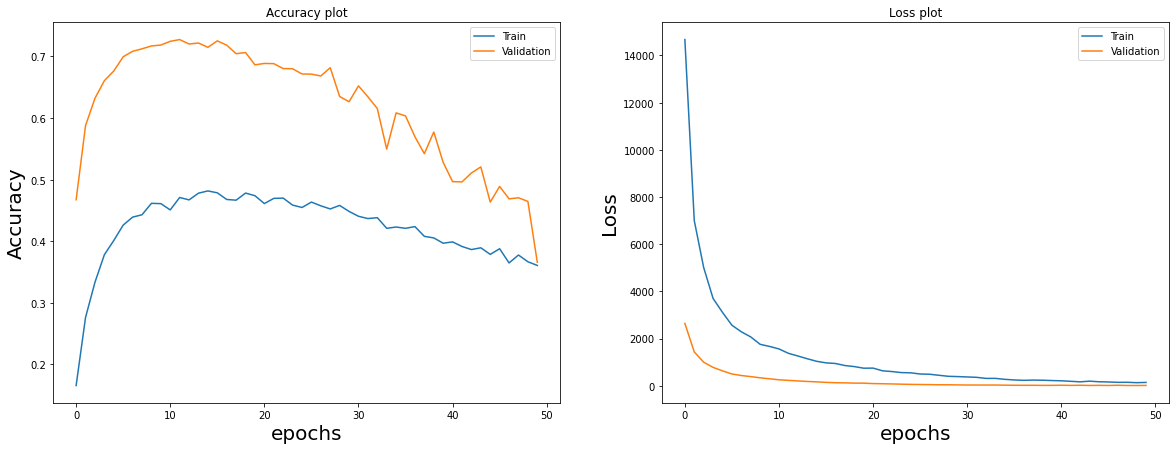

In [7]:
fig , (ax1, ax2)= plt.subplots(1, 2, figsize = (20, 7))
ax1.plot(a, label = "Train")
ax1.plot(b , label = "Validation")
ax1.set_title("Accuracy plot")
ax1.set_xlabel("epochs", fontsize = 20)
ax1.set_ylabel("Accuracy", fontsize = 20)

ax2.set_title("Loss plot")
ax2.plot(c, label = "Train")
ax2.plot(d, label = "Validation")
ax2.set_xlabel("epochs", fontsize= 20)
ax2.set_ylabel("Loss", fontsize = 20)
ax1.legend()
ax2.legend()
plt.savefig("Results.jpeg")
plt.show()

# A few exercises to try

a) Try writing a callback within the MLP class that can allow to break the training when it reaches some specified % of validation accuracy before all the epochs finish. 

b) Try varying the following and understand the effect on accuracy and losses: 
- the number of layers
- the input sizes of the layers
- dropout  

c) Create a small neural network (e.g. layers [2,2,1]) with some toy data (e.g. truth table of logical gate) and observe the weights in each iteration. Work it out on paper and check if the calculation matches.

# Some good resources

- [Neural Networks - Core Concepts and History, Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/08/evolution-core-concepts-deep-learning-neural-networks/)

- [Building Neural Networks from scratch using R and Python, Analytics Vidhya](https://www.analyticsvidhya.com/blog/2020/07/neural-networks-from-scratch-in-python-and-r/)

- [Understanding of Multilayer perceptron (MLP), Nitin Kumar Jain](https://medium.com/@AI_with_Kain/understanding-of-multilayer-perceptron-mlp-8f179c4a135f)

- [Understanding backprop, Andrej Karpathy](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)

- [Implementing XOR Gate using Back Propagation](https://towardsdatascience.com/implementing-the-xor-gate-using-backpropagation-in-neural-networks-c1f255b4f20d#:~:text=An%20XOR%20(exclusive%20OR%20gate,to%20the%20above%20truth%20table.)
